# MMDeploy本地部署预测-摄像头实时预测



## 本代码需在终端本地运行

## 导入工具包

In [1]:
import cv2
import numpy as np
import time
from tqdm import tqdm

from mmdeploy_runtime import Detector
from mmdeploy_runtime import PoseDetector

import matplotlib.pyplot as plt
%matplotlib inline

## 载入模型


需要把【H2】训练的模型copy到rtmdet2onnx和rtmpose2onnx文件夹，文件夹自建

另外我的【H2】代码没有包含目标检测的代码，自己改一下

In [3]:
# 目标检测模型目录
detect = 'rtmdet2onnx'

# 关键点检测模型目录
pose = 'rtmpose2onnx'

# 计算设备
device = 'cpu'
# device = 'cuda'

bbox_detector = Detector(detect, device)
pose_detector = PoseDetector(pose, device)

## 可视化配置

In [12]:
# 框（rectangle）可视化配置
bbox_label = 'person'              # 框的类别名称
bbox_color = (255, 129, 0)           # 框的 BGR 颜色
bbox_thickness = 5                   # 框的线宽

# 框类别文字
bbox_labelstr = {
    'font_size':6,         # 字体大小
    'font_thickness':10,    # 字体粗细
    'offset_x':0,          # X 方向，文字偏移距离，向右为正
    'offset_y':-80,        # Y 方向，文字偏移距离，向下为正
}

# 关键点 BGR 配色
kpt_color_map = {
    0: {'name': 'nose', 'color': [51, 153, 255], 'radius': 15},
    1: {'name': 'left_eye', 'color': [51, 153, 255], 'radius': 15},
    2: {'name': 'right_eye', 'color': [51, 153, 255], 'radius': 15},
    3: {'name': 'left_ear', 'color': [51, 153, 255], 'radius': 15},
    4: {'name': 'right_ear', 'color': [51, 153, 255], 'radius': 15},
    5: {'name': 'left_shoulder', 'color': [0, 255, 0], 'radius': 15},
    6: {'name': 'right_shoulder', 'color': [255, 128, 0], 'radius': 15},
    7: {'name': 'left_elbow', 'color': [0, 255, 0], 'radius': 15},
    8: {'name': 'right_elbow', 'color': [255, 128, 0], 'radius': 15},
    9: {'name': 'left_wrist', 'color': [0, 255, 0], 'radius': 15},
    10: {'name': 'right_wrist', 'color': [255, 128, 0], 'radius': 15},
    11: {'name': 'left_hip', 'color': [0, 255, 0], 'radius': 15},
    12: {'name': 'right_hip', 'color': [255, 128, 0], 'radius': 15},
    13: {'name': 'left_knee', 'color': [0, 255, 0], 'radius': 15},
    14: {'name': 'right_knee', 'color': [255, 128, 0], 'radius': 15},
    15: {'name': 'left_ankle', 'color': [0, 255, 0], 'radius': 15},
    16: {'name': 'right_ankle', 'color': [255, 128, 0], 'radius': 15},
}

# 关键点类别文字
kpt_labelstr = {
    'font_size':1,             # 字体大小
    'font_thickness':1,       # 字体粗细
    'offset_x':30,             # X 方向，文字偏移距离，向右为正
    'offset_y':50,            # Y 方向，文字偏移距离，向下为正
}

# 骨架连接 BGR 配色
skeleton_map = [
    {'srt_kpt_id': 15, 'dst_kpt_id': 13, 'color': [0, 255, 0], 'thickness': 8},  # left_ankle - left_knee
    {'srt_kpt_id': 13, 'dst_kpt_id': 11, 'color': [0, 255, 0], 'thickness': 8},  # left_knee - left_hip
    {'srt_kpt_id': 16, 'dst_kpt_id': 14, 'color': [255, 128, 0], 'thickness': 8}, # right_ankle - right_knee
    {'srt_kpt_id': 14, 'dst_kpt_id': 12, 'color': [255, 128, 0], 'thickness': 8}, # right_knee - right_hip
    {'srt_kpt_id': 11, 'dst_kpt_id': 12, 'color': [51, 153, 255], 'thickness': 8}, # left_hip - right_hip
    {'srt_kpt_id': 5, 'dst_kpt_id': 11, 'color': [51, 153, 255], 'thickness': 8},  # left_shoulder - left_hip
    {'srt_kpt_id': 6, 'dst_kpt_id': 12, 'color': [51, 153, 255], 'thickness': 8},  # right_shoulder - right_hip
    {'srt_kpt_id': 5, 'dst_kpt_id': 6, 'color': [51, 153, 255], 'thickness': 8},   # left_shoulder - right_shoulder
    {'srt_kpt_id': 5, 'dst_kpt_id': 7, 'color': [0, 255, 0], 'thickness': 8},      # left_shoulder - left_elbow
    {'srt_kpt_id': 6, 'dst_kpt_id': 9, 'color': [255, 128, 0], 'thickness': 8},   # right_shoulder - right_elbow
    {'srt_kpt_id': 7, 'dst_kpt_id': 9, 'color': [0, 255, 0], 'thickness': 8},      # left_elbow - left_wrist
    {'srt_kpt_id': 8, 'dst_kpt_id': 10, 'color': [255, 128, 0], 'thickness': 8},  # right_elbow - right_wrist
    {'srt_kpt_id': 1, 'dst_kpt_id': 2, 'color': [51, 153, 255], 'thickness': 8},  # left_eye - right_eye
    {'srt_kpt_id': 0, 'dst_kpt_id': 1, 'color': [51, 153, 255], 'thickness': 8},  # nose - left_eye
    {'srt_kpt_id': 0, 'dst_kpt_id': 2, 'color': [51, 153, 255], 'thickness': 8},  # nose - right_eye
    {'srt_kpt_id': 1, 'dst_kpt_id': 3, 'color': [51, 153, 255], 'thickness': 8},  # left_eye - left_ear
    {'srt_kpt_id': 2, 'dst_kpt_id': 4, 'color': [51, 153, 255], 'thickness': 8},  # right_eye - right_ear
    {'srt_kpt_id': 3, 'dst_kpt_id': 5, 'color': [51, 153, 255], 'thickness': 8},  # left_ear - left_shoulder
    {'srt_kpt_id': 4, 'dst_kpt_id': 6, 'color': [51, 153, 255], 'thickness': 8},  # right_ear - right_shoulder
]


## 逐帧处理函数

In [13]:
def process_frame(img_bgr):
    
    '''
    输入摄像头画面 bgr-array，输出图像 bgr-array
    '''
    
    # 记录该帧开始处理的时间
    start_time = time.time()

    # 目标检测推理预测
    bboxes, labels, masks = bbox_detector(img_bgr)

    # 置信度阈值过滤
    bboxes = bboxes[bboxes[:, -1] > 0.05]

    # 获取整数坐标
    bboxes = bboxes[:, :4].astype(np.int32)
    
    keypoints = pose_detector(img_bgr, bboxes)[:,:,:2].astype(np.int32)
    
    num_bbox = len(bboxes)

    for idx in range(num_bbox): # 遍历每个框

        # 获取该框坐标
        bbox_xyxy = bboxes[idx] 

        # 画框
        img_bgr = cv2.rectangle(img_bgr, (bbox_xyxy[0], bbox_xyxy[1]), (bbox_xyxy[2], bbox_xyxy[3]), bbox_color, bbox_thickness)

        # 写框类别文字：图片，文字字符串，文字左上角坐标，字体，字体大小，颜色，字体粗细
        img_bgr = cv2.putText(img_bgr, bbox_label, (bbox_xyxy[0]+bbox_labelstr['offset_x'], bbox_xyxy[1]+bbox_labelstr['offset_y']), cv2.FONT_HERSHEY_SIMPLEX, bbox_labelstr['font_size'], bbox_color, bbox_labelstr['font_thickness'])

        bbox_keypoints = keypoints[idx] # 该框所有关键点坐标和置信度

        # 画该框的骨架连接
        for skeleton in skeleton_map:

            # 获取起始点坐标
            srt_kpt_id = skeleton['srt_kpt_id']
            srt_kpt_x = bbox_keypoints[srt_kpt_id][0]
            srt_kpt_y = bbox_keypoints[srt_kpt_id][1]

            # 获取终止点坐标
            dst_kpt_id = skeleton['dst_kpt_id']
            dst_kpt_x = bbox_keypoints[dst_kpt_id][0]
            dst_kpt_y = bbox_keypoints[dst_kpt_id][1]

            # 获取骨架连接颜色
            skeleton_color = skeleton['color']

            # 获取骨架连接线宽
            skeleton_thickness = skeleton['thickness']

            # 画骨架连接
            img_bgr = cv2.line(img_bgr, (srt_kpt_x, srt_kpt_y),(dst_kpt_x, dst_kpt_y),color=skeleton_color,thickness=skeleton_thickness)  

        # 画该框的关键点
        for kpt_id in kpt_color_map:

            # 获取该关键点的颜色、半径、XY坐标
            kpt_color = kpt_color_map[kpt_id]['color']
            kpt_radius = kpt_color_map[kpt_id]['radius']
            kpt_x = bbox_keypoints[kpt_id][0]
            kpt_y = bbox_keypoints[kpt_id][1]

            # 画圆：图片、XY坐标、半径、颜色、线宽（-1为填充）
            img_bgr = cv2.circle(img_bgr, (kpt_x, kpt_y), kpt_radius, kpt_color, -1)

            # 写关键点类别文字：图片，文字字符串，文字左上角坐标，字体，字体大小，颜色，字体粗细
            kpt_label = str(kpt_id) # 写关键点类别 ID（二选一）
            # kpt_label = str(kpt_color_map[kpt_id]['name']) # 写关键点类别名称（二选一）
            img_bgr = cv2.putText(img_bgr, kpt_label, (kpt_x+kpt_labelstr['offset_x'], kpt_y+kpt_labelstr['offset_y']), cv2.FONT_HERSHEY_SIMPLEX, kpt_labelstr['font_size'], kpt_color, kpt_labelstr['font_thickness'])

    # 记录该帧处理完毕的时间
    end_time = time.time()
    # 计算每秒处理图像帧数FPS
    FPS = 1/(end_time - start_time)

    # 在画面上写字：图片，字符串，左上角坐标，字体，字体大小，颜色，字体粗细
    FPS_string = 'FPS {:.2f}'.format(FPS)  # 写在画面上的字符串
    img_bgr = cv2.putText(img_bgr, FPS_string, (25, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255, 0, 255), 2)
    
    return img_bgr

## 摄像头拍摄单帧画面

In [14]:
# 获取摄像头，0为电脑默认摄像头，1为外接摄像头
cap = cv2.VideoCapture(0)

# 拍照
time.sleep(1) # 运行本代码后等几秒拍照
# 从摄像头捕获一帧画面
success, frame = cap.read()

cap.release() # 关闭摄像头
cv2.destroyAllWindows() # 关闭图像窗口

In [15]:
frame.shape

(480, 640, 3)

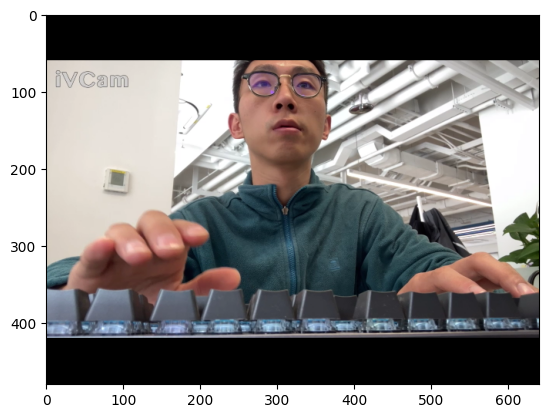

In [16]:
plt.imshow(frame[:,:,::-1])
plt.show()

## 单帧画面关键点检测预测

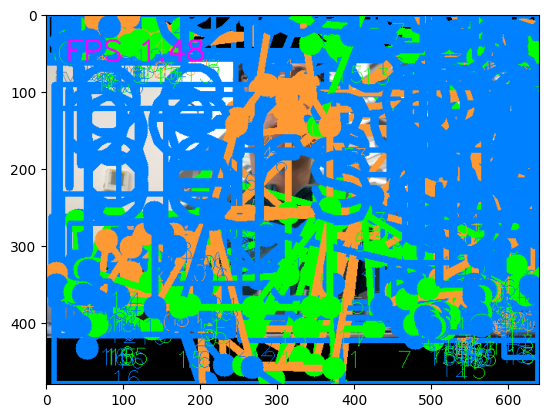

In [17]:
img_bgr = process_frame(frame)

plt.imshow(img_bgr[:,:,::-1])
plt.show()

## 摄像头实时画面逐帧处理（模板）

In [7]:
# 调用摄像头逐帧实时处理模板
# 不需修改任何代码，只需修改process_frame函数即可
# 同济子豪兄 2021-7-8

# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

# 无限循环，直到break被触发
while cap.isOpened():
    
    # 获取画面
    success, frame = cap.read()
    
    if not success: # 如果获取画面不成功，则退出
        print('获取画面不成功，退出')
        break
    
    ## 逐帧处理
    frame = process_frame(frame)
    
    # 展示处理后的三通道图像
    cv2.imshow('my_window',frame)
    
    key_pressed = cv2.waitKey(60) # 每隔多少毫秒毫秒，获取键盘哪个键被按下
    # print('键盘上被按下的键：', key_pressed)

    if key_pressed in [ord('q'),27]: # 按键盘上的q或esc退出（在英文输入法下）
        break
    
# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()

## 按`q`键或`Esc`键关闭画面